In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import load_iris, load_wine, fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time


In [205]:
random_state = 222


## zad 1

**Principal Component Analysis (PCA)** to technika redukcji wymiarowości, która znajduje główne kierunki wariancji w danych i projektuje je na przestrzeń o mniejszej liczbie wymiarów.

<center>
    <img src="./screens/l6-pca-cel.png" style="width: 60%;">
</center>

Wygeneruję syntetyczny zbiór danych w 3D, gdzie punkty układają się w linii lub płaszczyźnie, a następnie zastosuję PCA do redukcji do 2D.


In [206]:
np.random.seed(random_state)

n_samples = 5000

# linia
t = np.linspace(0, 100, n_samples)
X_line_3d = np.column_stack([
    t,
    t + np.random.normal(0, 0.1, n_samples),
    t + np.random.normal(0, 0.1, n_samples)
])

# płaszczyzna
X_plane_3d = np.random.rand(n_samples, 2)
X_plane_3d = np.column_stack([
    X_plane_3d[:, 0],
    X_plane_3d[:, 1],
    X_plane_3d[:, 0] + X_plane_3d[:, 1] + np.random.normal(0, 0.1, n_samples)
])


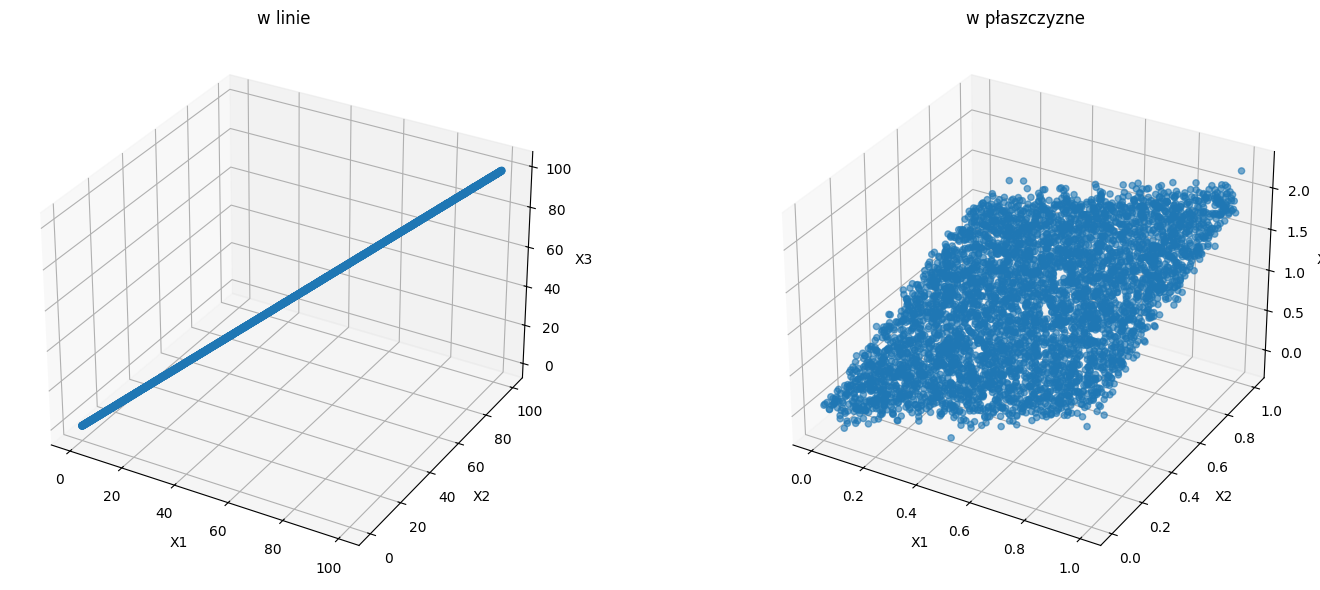

In [207]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_line_3d[:, 0], X_line_3d[:, 1], X_line_3d[:, 2], alpha=0.6, s=20)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')
ax1.set_title('w linie')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_plane_3d[:, 0], X_plane_3d[:, 1], X_plane_3d[:, 2], alpha=0.6, s=20)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('X3')
ax2.set_title('w płaszczyzne')

plt.tight_layout()
plt.show()


Teraz zastosuje PCA z scikit learn

<center>
    <img src="./screens/l6-pca-opt.png" style="width: 60%;">
</center>

linia:

In [208]:
pca_line = PCA(n_components=2, random_state=random_state)
X_line_2d = pca_line.fit_transform(X_line_3d)

płaszczyzna

In [209]:
pca_plane = PCA(n_components=2, random_state=random_state)
X_plane_2d = pca_plane.fit_transform(X_plane_3d)

Podsumowanie

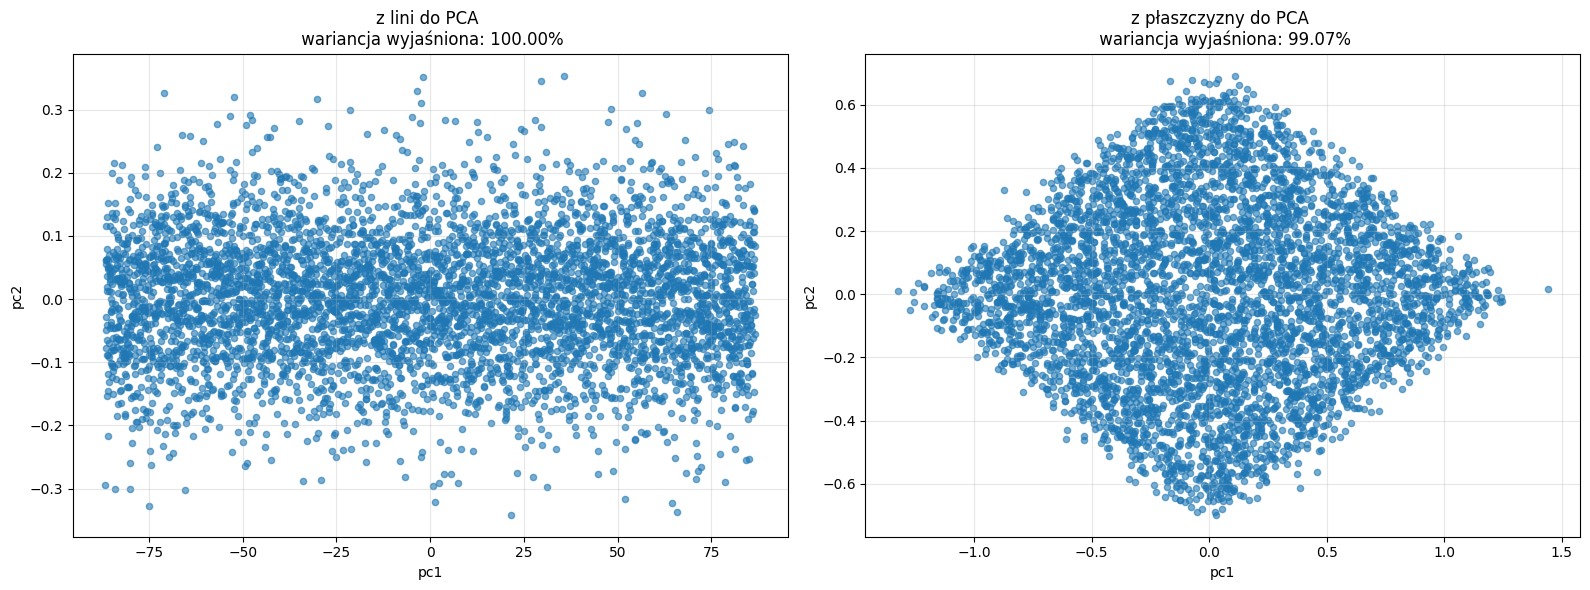

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_line_2d[:, 0], X_line_2d[:, 1], alpha=0.6, s=20)
axes[0].set_xlabel('pc1')
axes[0].set_ylabel('pc2')
axes[0].set_title(f'z lini do PCA \n wariancja wyjaśniona: {pca_line.explained_variance_ratio_.sum():.2%}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_plane_2d[:, 0], X_plane_2d[:, 1], alpha=0.6, s=20)
axes[1].set_xlabel('pc1')
axes[1].set_ylabel('pc2')
axes[1].set_title(f'z płaszczyzny do PCA \n wariancja wyjaśniona: {pca_plane.explained_variance_ratio_.sum():.2%}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Wnioski:
- dla danych układających się w linii, PCA skutecznie redukuje wymiarowość z 3D do 2D, zachowując prawie całą wariancję (ponieważ dane leżą głównie w jednym wymiarze)
- dla danych w płaszczyźnie, redukcja do 2D również zachowuje większość wariancji, ponieważ dane są z natury dwuwymiarowe
- PCA znajduje główne kierunki wariancji i projektuje dane na te kierunki


## zad 2

Analiza wariancji wyjaśnionej pozwala określić, ile głównych składowych należy zachować, aby wyjaśnić określony procent całkowitej wariancji.
Użyję zbioru danych **Wine**.

<center>
    <img src="./screens/l6-wybor-skladowych.png" style="width: 60%;">
</center>

In [211]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print(f"Liczba próbek: {X_wine.shape[0]}")
print(f"Liczba cech: {X_wine.shape[1]}")
print(f"Liczba klas: {len(np.unique(y_wine))}")


Liczba próbek: 178
Liczba cech: 13
Liczba klas: 3


In [212]:
pd.DataFrame(X_wine, columns=wine.feature_names).head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Skaluje dane i używam PCA

In [213]:
scaler_wine = StandardScaler()
X_wine_scaled = scaler_wine.fit_transform(X_wine)

pca_wine = PCA(random_state=random_state)
X_wine_pca = pca_wine.fit_transform(X_wine_scaled)

Główna część zadania:

In [214]:
explained_variance = pca_wine.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"liczba składowych do wyjaśnienia 95% wariancji: {n_components_95}")
print(f"wariancja wyjaśniona przez {n_components_95} komponentów: {cumulative_variance[n_components_95-1]:.4f}")


liczba składowych do wyjaśnienia 95% wariancji: 10
wariancja wyjaśniona przez 10 komponentów: 0.9617


/tmp/ipykernel_18549/3256648236.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


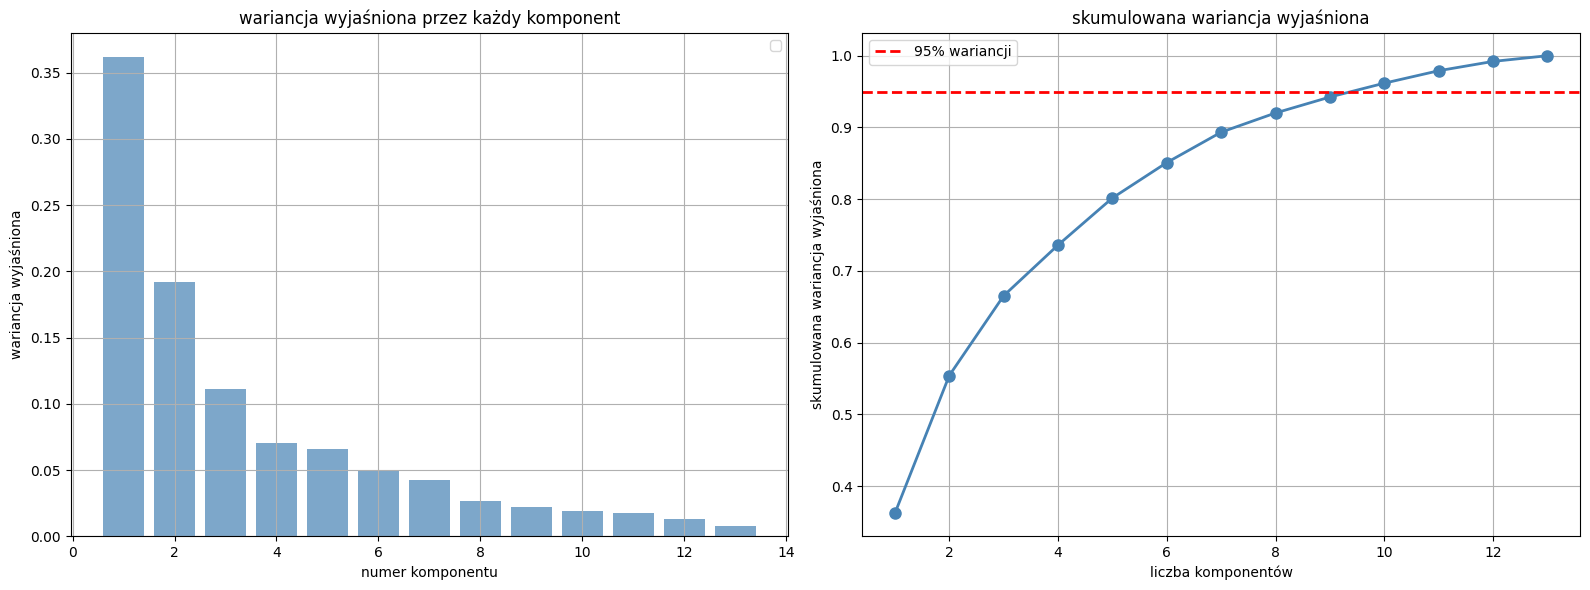

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

components = range(1, len(explained_variance) + 1)
ax1.bar(components, explained_variance, alpha=0.7, color='steelblue')
ax1.set_xlabel('numer komponentu')
ax1.set_ylabel('wariancja wyjaśniona')
ax1.set_title('wariancja wyjaśniona przez każdy komponent')
ax1.legend()
ax1.grid(True)

ax2.plot(components, cumulative_variance, 'o-', linewidth=2, markersize=8, color='steelblue')
ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% wariancji')
ax2.set_xlabel('liczba komponentów')
ax2.set_ylabel('skumulowana wariancja wyjaśniona')
ax2.set_title('skumulowana wariancja wyjaśniona')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Wnioski:
- pierwsze kilka głównych składowych wyjaśnia większość wariancji w danych
- dla zbioru Wine, około **10 głównych składowych** wystarczy do wyjaśnienia 95% całkowitej wariancji
- możemy zredukować wymiarowość z 13 do 10 wymiarów, zachowując 95% informacji


## zad 3

Wizualizacja wielowymiarowych danych jest trudna, gdy mamy więcej niż 2-3 wymiary. PCA pozwala zredukować dane do 2D lub 3D, zachowując jak najwięcej informacji, co umożliwia wizualizację i analizę wzorców w danych.

In [216]:
pca_wine_2d = PCA(n_components=2, random_state=random_state)
X_wine_pca_2d = pca_wine_2d.fit_transform(X_wine_scaled)

print(f"wariancja wyjaśniona przez PC1: {pca_wine_2d.explained_variance_ratio_[0]:.4f}")
print(f"wariancja wyjaśniona przez PC2: {pca_wine_2d.explained_variance_ratio_[1]:.4f}")
print(f"całkowita wariancja wyjaśniona: {pca_wine_2d.explained_variance_ratio_.sum():.4f}")

wariancja wyjaśniona przez PC1: 0.3620
wariancja wyjaśniona przez PC2: 0.1921
całkowita wariancja wyjaśniona: 0.5541


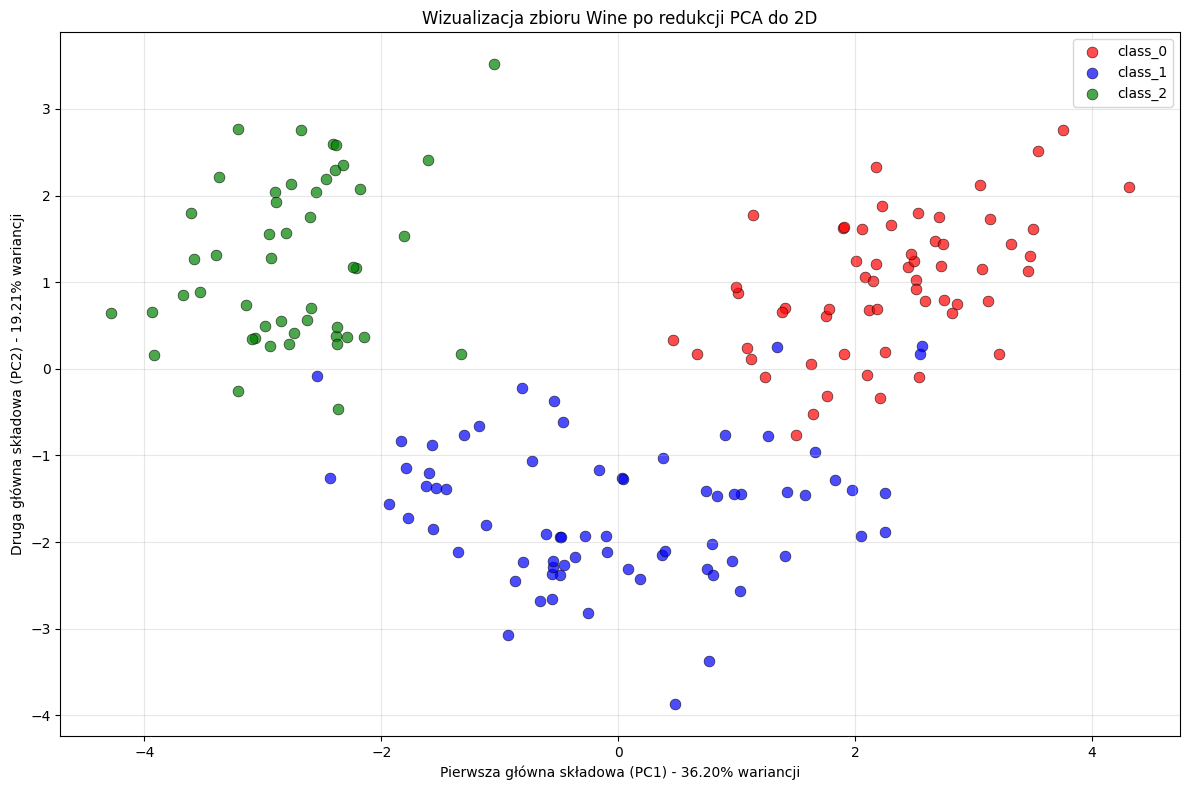

In [217]:
wine_target_names = wine.target_names
colors = ['red', 'blue', 'green']

plt.figure(figsize=(12, 8))
for i, (color, target_name) in enumerate(zip(colors, wine_target_names)):
    plt.scatter(
        X_wine_pca_2d[y_wine == i, 0],
        X_wine_pca_2d[y_wine == i, 1],
        c=color,
        label=target_name,
        alpha=0.7,
        s=60,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel(f'Pierwsza główna składowa (PC1) - {pca_wine_2d.explained_variance_ratio_[0]:.2%} wariancji')
plt.ylabel(f'Druga główna składowa (PC2) - {pca_wine_2d.explained_variance_ratio_[1]:.2%} wariancji')
plt.title('Wizualizacja zbioru Wine po redukcji PCA do 2D')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Czy PCA jest skuteczną metodą do wizualizacji w tym przypadku? tak

1. wizualizacja pokazuje separację między klasami win, choć nie jest idealna
2. dwie główne składowe wyjaśniają około 55% całkowitej wariancji


## zad 4

PCA może być używane jako pre-processing przed trenowaniem modeli uczenia maszynowego. Redukcja wymiarowości może:
- przyspieszyć trening, mniej cech oznacza szybsze obliczenia
- zmniejszyć przeuczenie, mniej parametrów do dopasowania
- poprawić wydajność, usunięcie szumu i redundantnych cech

Porównam model klasyfikacyjny (SVM) na danych Wine bez redukcji wymiarowości i z PCA redukującym do 5 głównych składowych.

In [218]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(
    X_wine_scaled, y_wine, test_size=0.3, random_state=random_state, stratify=y_wine
)

print(f"Zbiór treningowy: {X_wine_train.shape[0]} próbek")
print(f"Zbiór testowy: {X_wine_test.shape[0]} próbek")


Zbiór treningowy: 124 próbek
Zbiór testowy: 54 próbek


Bez PCA

In [219]:
svm_no_pca = SVC(kernel='rbf', random_state=random_state)

start_time = time.time()
svm_no_pca.fit(X_wine_train, y_wine_train)
train_time_no_pca = time.time() - start_time

start_time = time.time()
y_pred_no_pca = svm_no_pca.predict(X_wine_test)
pred_time_no_pca = time.time() - start_time

accuracy_no_pca = accuracy_score(y_wine_test, y_pred_no_pca)

print(f"Model bez PCA:")
print(f"- dokładność: {accuracy_no_pca:.4f}")
print(f"- czas treningu: {train_time_no_pca:.4f} s")
print(f"- czas predykcji: {pred_time_no_pca:.4f} s")

Model bez PCA:
- dokładność: 1.0000
- czas treningu: 0.0012 s
- czas predykcji: 0.0003 s


z PCA 5 wymiarów

In [220]:
pca_wine_2d_for_model_5 = PCA(n_components=5, random_state=random_state)
X_wine_train_pca_5 = pca_wine_2d_for_model_5.fit_transform(X_wine_train)
X_wine_test_pca_5 = pca_wine_2d_for_model_5.transform(X_wine_test)

print(f"wariancja wyjaśniona przez 5 komponentów: {pca_wine_2d_for_model_5.explained_variance_ratio_.sum():.4f}")

svm_with_pca = SVC(kernel='rbf', random_state=random_state)

start_time = time.time()
svm_with_pca.fit(X_wine_train_pca_5, y_wine_train)
train_time_with_pca_5 = time.time() - start_time

start_time = time.time()
y_pred_with_pca_5 = svm_with_pca.predict(X_wine_test_pca_5)
pred_time_with_pca_5 = time.time() - start_time

accuracy_with_pca_5 = accuracy_score(y_wine_test, y_pred_with_pca_5)

print(f"Model z PCA:")
print(f"- dokładność: {accuracy_with_pca_5:.4f}")
print(f"- czas treningu: {train_time_with_pca_5:.4f} s")
print(f"- czas predykcji: {pred_time_with_pca_5:.4f} s")


wariancja wyjaśniona przez 5 komponentów: 0.8049
Model z PCA:
- dokładność: 1.0000
- czas treningu: 0.0009 s
- czas predykcji: 0.0002 s


z PCA 2 wymiary

In [221]:
pca_wine_2d_for_model_2 = PCA(n_components=2, random_state=random_state)
X_wine_train_pca_2 = pca_wine_2d_for_model_2.fit_transform(X_wine_train)
X_wine_test_pca_2 = pca_wine_2d_for_model_2.transform(X_wine_test)

print(f"wariancja wyjaśniona przez 2 komponenty: {pca_wine_2d_for_model_2.explained_variance_ratio_.sum():.4f}")

svm_with_pca = SVC(kernel='rbf', random_state=random_state)

start_time = time.time()
svm_with_pca.fit(X_wine_train_pca_2, y_wine_train)
train_time_with_pca_2 = time.time() - start_time

start_time = time.time()
y_pred_with_pca_2 = svm_with_pca.predict(X_wine_test_pca_2)
pred_time_with_pca_2 = time.time() - start_time

accuracy_with_pca_2 = accuracy_score(y_wine_test, y_pred_with_pca_2)

print(f"Model z PCA:")
print(f"- dokładność: {accuracy_with_pca_2:.4f}")
print(f"- czas treningu: {train_time_with_pca_2:.4f} s")
print(f"- czas predykcji: {pred_time_with_pca_2:.4f} s")


wariancja wyjaśniona przez 2 komponenty: 0.5579
Model z PCA:
- dokładność: 0.9815
- czas treningu: 0.0009 s
- czas predykcji: 0.0003 s


Wnioski

In [222]:
comparison_df = pd.DataFrame({
    'Model': ['Bez PCA (13 cech)', 'Z PCA (5 komponentów)', 'Z PCA (2 komponenty)'],
    'Dokładność': [accuracy_no_pca, accuracy_with_pca_5, accuracy_with_pca_2],
    'Czas treningu [s]': [train_time_no_pca, train_time_with_pca_5, train_time_with_pca_2],
    'Czas predykcji [s]': [pred_time_no_pca, pred_time_with_pca_5, pred_time_with_pca_2],
    'Liczba cech': [X_wine_train.shape[1], X_wine_train_pca_5.shape[1], X_wine_train_pca_2.shape[1]]
})

comparison_df


,Model,Dokładność,Czas treningu [s],Czas predykcji [s],Liczba cech
0,Bez PCA (13 cech),1.000000,0.001189,0.000250,13
1,Z PCA (5 komponentów),1.000000,0.000930,0.000211,5
2,Z PCA (2 komponenty),0.981481,0.000921,0.000311,2


wnioski:
- czas treningu: model z PCA jest szybszy
- dokładność: zbyt prosty zbiór
- zastosowanie: PCA jako pre-processing jest szczególnie przydatne, gdy mamy bardzo dużo cech lub gdy chcemy szybko eksperymentować z modelami


## zad 5

**Linear Discriminant Analysis (LDA)** to metoda redukcji wymiarowości, która różni się od PCA:

<center>
    <img src="./screens/l6-lca-about.png" style="width: 60%;">
</center>

LDA wykorzystuje informacje o klasach, aby znaleźć kierunki, które najlepiej rozdzielają różne klasy.

<center>
    <img src="./screens/l6-lca-vs-pca.png" style="width: 60%;">
</center>

Porównam LDA z PCA na zbiorze danych Wine.


In [223]:
lda_wine = LDA(n_components=2)
X_wine_lda = lda_wine.fit_transform(X_wine_scaled, y_wine)

print(f"wariancja wyjaśniona przez LDA:")
print(f"- komponent 1: {lda_wine.explained_variance_ratio_[0]:.4f}")
print(f"- komponent 2: {lda_wine.explained_variance_ratio_[1]:.4f}")
print(f"- całkowita: {lda_wine.explained_variance_ratio_.sum():.4f}")

print(f"wariancja wyjaśniona przez PCA:")
print(f"- komponent 1: {pca_wine_2d.explained_variance_ratio_[0]:.4f}")
print(f"- komponent 2: {pca_wine_2d.explained_variance_ratio_[1]:.4f}")
print(f"- całkowita: {pca_wine_2d.explained_variance_ratio_.sum():.4f}")


wariancja wyjaśniona przez LDA:
- komponent 1: 0.6875
- komponent 2: 0.3125
- całkowita: 1.0000
wariancja wyjaśniona przez PCA:
- komponent 1: 0.3620
- komponent 2: 0.1921
- całkowita: 0.5541


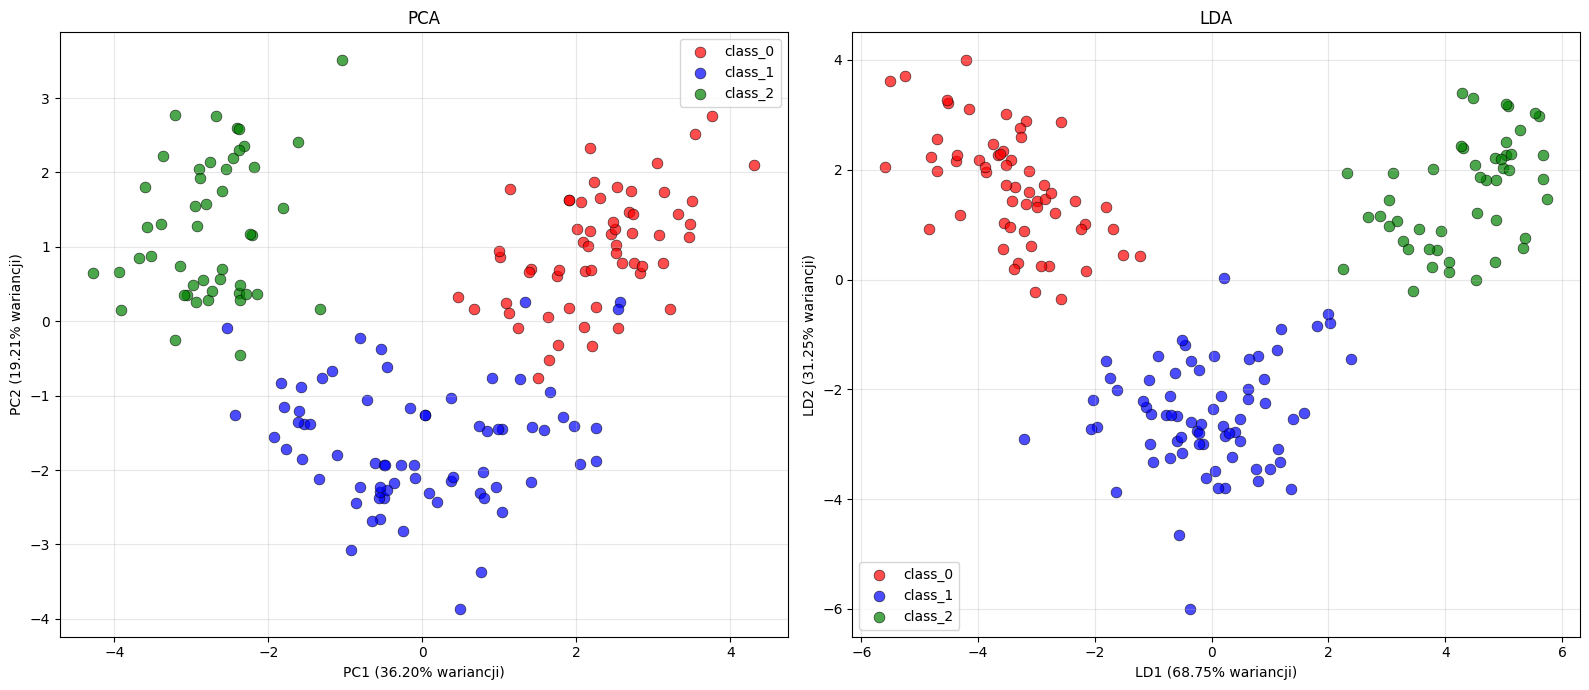

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

wine_target_names = wine.target_names
colors = ['red', 'blue', 'green']

# PCA
for i, (color, target_name) in enumerate(zip(colors, wine_target_names)):
    axes[0].scatter(
        X_wine_pca_2d[y_wine == i, 0],
        X_wine_pca_2d[y_wine == i, 1],
        c=color,
        label=target_name,
        alpha=0.7,
        s=60,
        edgecolors='black',
        linewidth=0.5
    )
axes[0].set_xlabel(f'PC1 ({pca_wine_2d.explained_variance_ratio_[0]:.2%} wariancji)')
axes[0].set_ylabel(f'PC2 ({pca_wine_2d.explained_variance_ratio_[1]:.2%} wariancji)')
axes[0].set_title('PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LDA
for i, (color, target_name) in enumerate(zip(colors, wine_target_names)):
    axes[1].scatter(
        X_wine_lda[y_wine == i, 0],
        X_wine_lda[y_wine == i, 1],
        c=color,
        label=target_name,
        alpha=0.7,
        s=60,
        edgecolors='black',
        linewidth=0.5
    )
axes[1].set_xlabel(f'LD1 ({lda_wine.explained_variance_ratio_[0]:.2%} wariancji)')
axes[1].set_ylabel(f'LD2 ({lda_wine.explained_variance_ratio_[1]:.2%} wariancji)')
axes[1].set_title('LDA')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Wnioski: LCA wypada zdecydowanie lepiej

## zad 6

Zastosuję PCA do redukcji wymiarowości obrazów i wyświetlę oryginalne obrazy oraz ich zrekonstruowane wersje.
PCA może być używane do:
- redukcji wymiarowości dla obrazów, które mają bardzo dużo pikseli
- ompresji obrazów

In [225]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home=None)

X_lfw = lfw_people.data
y_lfw = lfw_people.target
target_names_lfw = lfw_people.target_names
n_samples, h, w = lfw_people.images.shape

print(f"wymiary obrazu: {h}x{w} = {h*w} ")
print(f"liczba osób: {len(target_names_lfw)}")
print(f"osoby: {target_names_lfw}")


wymiary obrazu: 50x37 = 1850 
liczba osób: 7
osoby: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


Orginalne

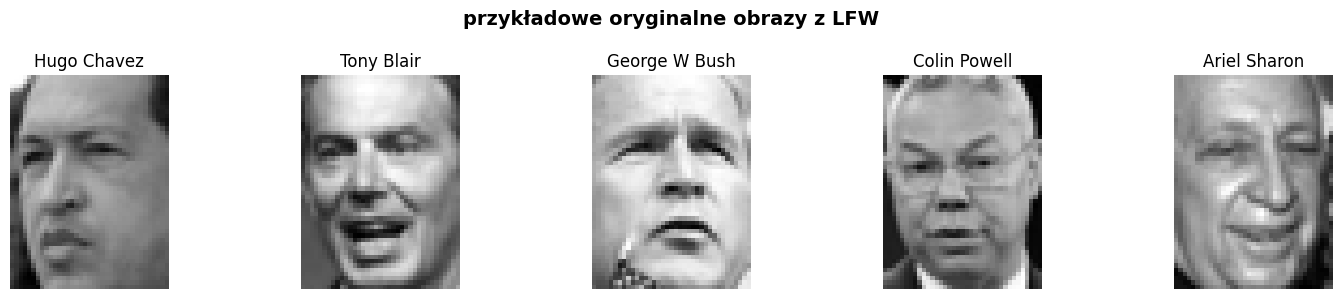

In [226]:
n_faces = 5
fig, axes = plt.subplots(1, n_faces, figsize=(15, 3))
for i in range(n_faces):
    axes[i].imshow(lfw_people.images[i], cmap='gray')
    axes[i].set_title(target_names_lfw[y_lfw[i]])
    axes[i].axis('off')
plt.suptitle('przykładowe oryginalne obrazy z LFW', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Używam PCA

In [227]:
n_components_list = [25, 70, 150]

pca_models = {}
X_lfw_reconstructed = {}

for n_comp in n_components_list:
    pca_face = PCA(n_components=n_comp, random_state=random_state)
    X_lfw_pca = pca_face.fit_transform(X_lfw)
    X_lfw_reconstructed[n_comp] = pca_face.inverse_transform(X_lfw_pca)
    pca_models[n_comp] = pca_face
    
    explained_var = pca_face.explained_variance_ratio_.sum()
    print(f"PCA z {n_comp} komponentami:")
    print(f"wyjasniniona wariancja {explained_var:.4f} ({explained_var*100:.2f}%)")
    print(f"kompresja {h*w} pikseli -> {n_comp} komponentów ({n_comp/(h*w)*100:.2f}% oryginalnego rozmiaru)")


PCA z 25 komponentami:
wyjasniniona wariancja 0.7626 (76.26%)
kompresja 1850 pikseli -> 25 komponentów (1.35% oryginalnego rozmiaru)
PCA z 70 komponentami:
wyjasniniona wariancja 0.8781 (87.81%)
kompresja 1850 pikseli -> 70 komponentów (3.78% oryginalnego rozmiaru)
PCA z 150 komponentami:
wyjasniniona wariancja 0.9427 (94.27%)
kompresja 1850 pikseli -> 150 komponentów (8.11% oryginalnego rozmiaru)


I zobaczmy na plocie

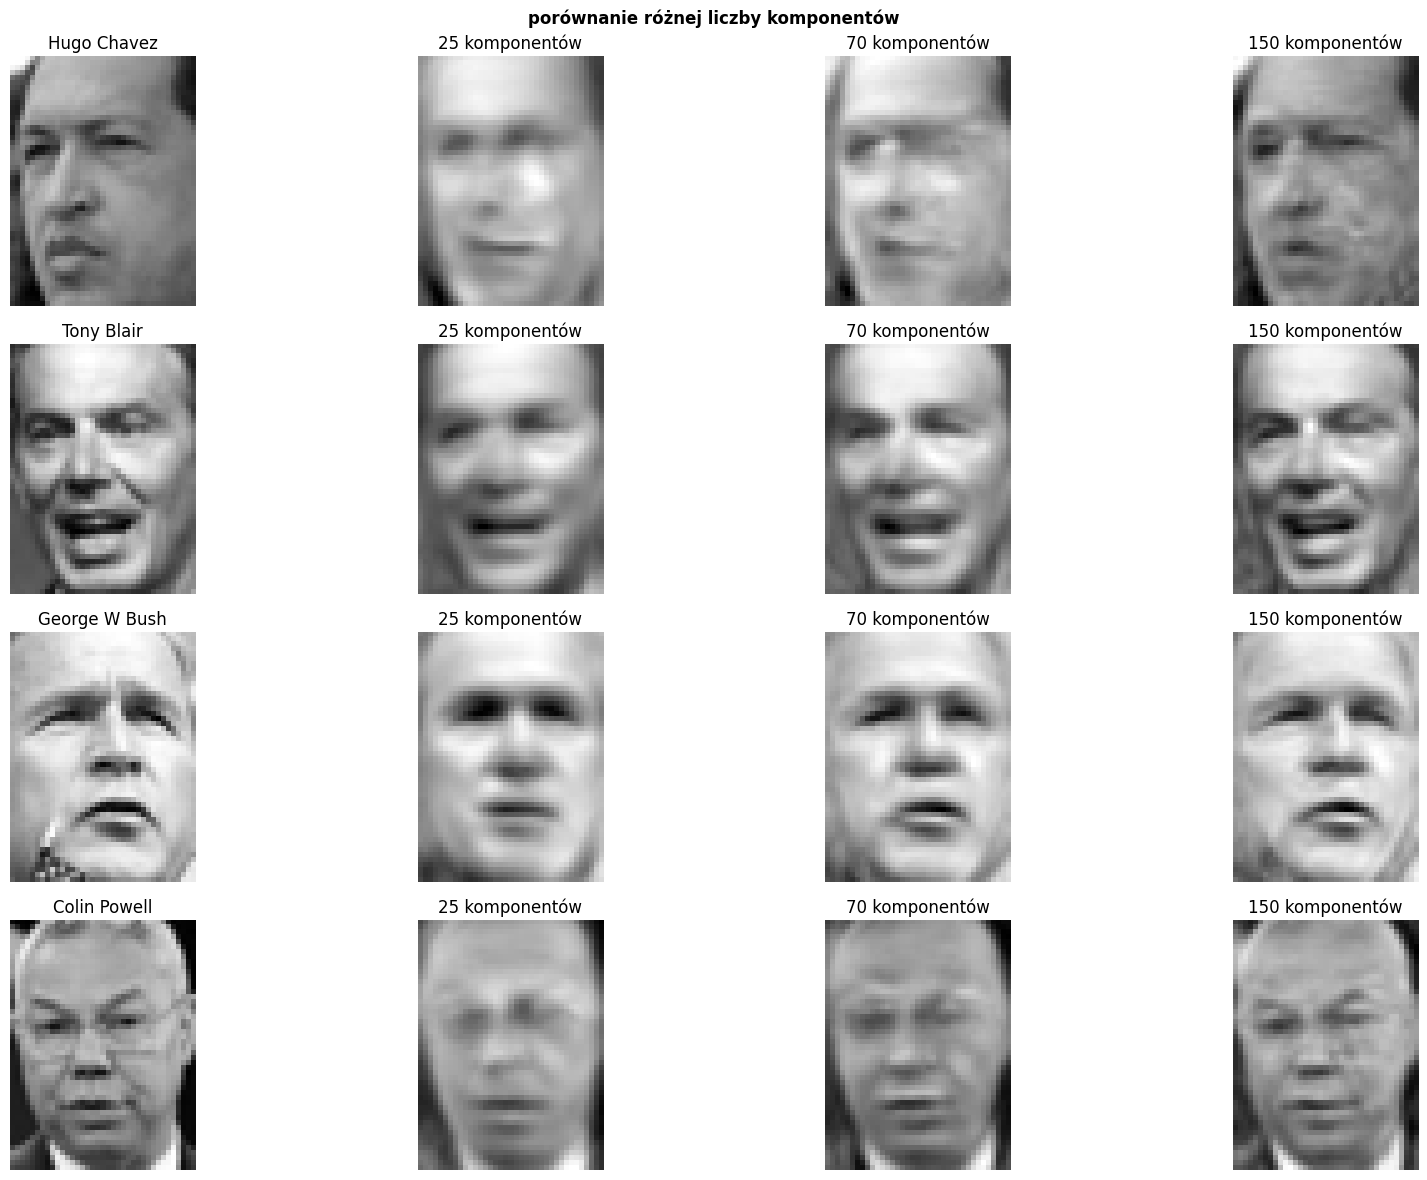

In [233]:
n_faces_to_show = 4
n_components_to_show = [25, 70, 150]

fig, axes = plt.subplots(n_faces_to_show, len(n_components_to_show) + 1, figsize=(18, 12))

for face_idx in range(n_faces_to_show):
    axes[face_idx, 0].imshow(lfw_people.images[face_idx], cmap='gray')
    axes[face_idx, 0].set_title(f'{target_names_lfw[y_lfw[face_idx]]}')
    axes[face_idx, 0].axis('off')
    
    for comp_idx, n_comp in enumerate(n_components_to_show):
        reconstructed = X_lfw_reconstructed[n_comp][face_idx].reshape(h, w)
        axes[face_idx, comp_idx + 1].imshow(reconstructed, cmap='gray')
        var_explained = pca_models[n_comp].explained_variance_ratio_.sum()
        axes[face_idx, comp_idx + 1].set_title(f'{n_comp} komponentów')
        axes[face_idx, comp_idx + 1].axis('off')

plt.suptitle('porównanie różnej liczby komponentów', fontweight='bold')
plt.tight_layout()
plt.show()


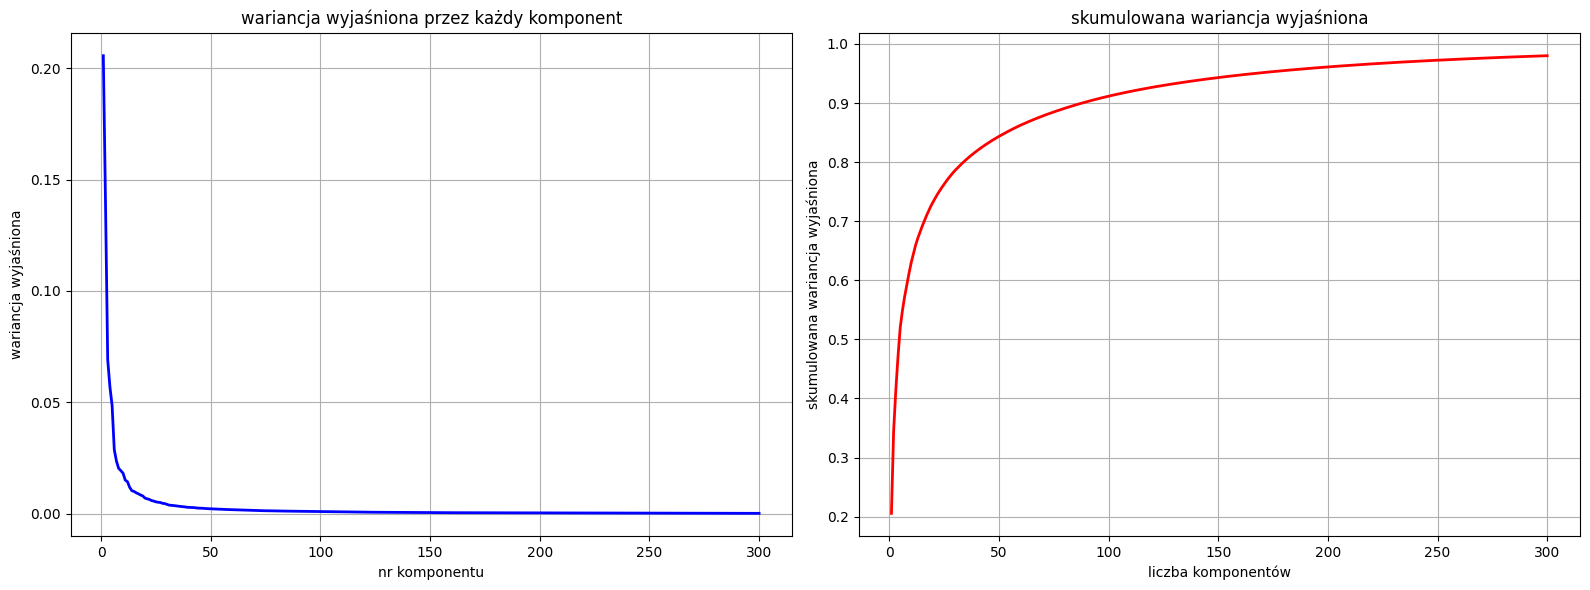

In [229]:
pca_full = PCA(random_state=random_state)
X_lfw_pca_full = pca_full.fit_transform(X_lfw)
explained_variance_lfw = pca_full.explained_variance_ratio_
cumulative_variance_lfw = np.cumsum(explained_variance_lfw)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

components_range = range(1, min(300, len(explained_variance_lfw)) + 1)
ax1.plot(components_range, explained_variance_lfw[:len(components_range)], 'b-', linewidth=2)
ax1.set_xlabel('nr komponentu')
ax1.set_ylabel('wariancja wyjaśniona')
ax1.set_title('wariancja wyjaśniona przez każdy komponent')
ax1.grid(True)

ax2.plot(components_range, cumulative_variance_lfw[:len(components_range)], 'r-', linewidth=2)
ax2.set_xlabel('liczba komponentów')
ax2.set_ylabel('skumulowana wariancja wyjaśniona')
ax2.set_title('skumulowana wariancja wyjaśniona')
ax2.grid(True)

plt.tight_layout()
plt.show()
